In [1]:
#!conda install herbie-data -c conda-forge

In [2]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

# Skill from HRRR downloaded with `herbie`

[`herbie`](https://herbie.readthedocs.io/en/latest/user_guide/_tutorial_notebooks/fast.html) downloads forecasts data easily. The resulting datasets is out-of-the-box compatible with `climpred`.

In [3]:
import xarray as xr
import numpy as np

import climpred  # forecast verification

<IPython.core.display.Javascript object>

In [7]:
from herbie import Herbie

H = Herbie(date="2022-01-27 00:00", model="ecmwf", product="enfo", fxx=6)
ds = H.xarray(":2t:")
ds

✅ Found ┊ model=ecmwf ┊ product=enfo ┊ 2022-Jan-27 00:00 UTC F06 ┊ GRIB2 @ azure ┊ IDX @ azure
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.


[<xarray.Dataset>
 Dimensions:              (number: 50, latitude: 451, longitude: 900)
 Coordinates:
   * number               (number) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
     time                 datetime64[ns] 2022-01-27
     step                 timedelta64[ns] 06:00:00
     heightAboveGround    float64 2.0
   * latitude             (latitude) float64 90.0 89.6 89.2 ... -89.2 -89.6 -90.0
   * longitude            (longitude) float64 -180.0 -179.6 ... 179.2 179.6
     valid_time           datetime64[ns] 2022-01-27T06:00:00
 Data variables:
     t2m                  (number, latitude, longitude) float32 251.0 ... 243.6
     gribfile_projection  object None
 Attributes:
     GRIB_edition:            2
     GRIB_centre:             ecmf
     GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
     GRIB_subCentre:          0
     Conventions:             CF-1.7
     institution:             European Centre for Medium-Range Weather Forecasts
     model

<IPython.core.display.Javascript object>

## Forecast skill verification

Using {py:class}`.PerfectModelEnsemble` because we don't fetch ground truth observations, if observations are available use {py:class}`.HindcastEnsemble`.

`climpred` expects `init`, `lead` and optional `member` as dimensions, see [setting-up-your-dataset](setting-up-data.html#setting-up-your-dataset). Existing dimensions are renamed automatically if CF `standard_names` match.

In [8]:
# hindcast = climpred.PerfectModelEnsemble(ds.drop_vars("valid_time")) # existing valid_time might lead to errors
hindcast = climpred.PerfectModelEnsemble(ds[0][["t2m"]].expand_dims(["time", "step"]))

/srv/conda/envs/notebook/lib/python3.10/site-packages/climpred/checks.py:202: UserWarning: Did not find dimension "init", but renamed dimension time with CF-complying standard_name "forecast_reference_time" to init.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/climpred/checks.py:202: UserWarning: Did not find dimension "member", but renamed dimension number with CF-complying standard_name "realization" to member.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/climpred/checks.py:202: UserWarning: Did not find dimension "lead", but renamed dimension step with CF-complying standard_name "forecast_period" to lead.
  warnings.warn(


<IPython.core.display.Javascript object>

In [9]:
hindcast

<climpred.PerfectModelEnsemble>
Initialized:
    t2m      (init, lead, member, latitude, longitude) float32 251.0 ... 243.6
Uninitialized:
    None
Control:
    None

<IPython.core.display.Javascript object>

In [10]:
skill = hindcast.isel(member=range(10)).verify(
    metric="crps", comparison="m2m", dim=["init", "member"]
)

<IPython.core.display.Javascript object>

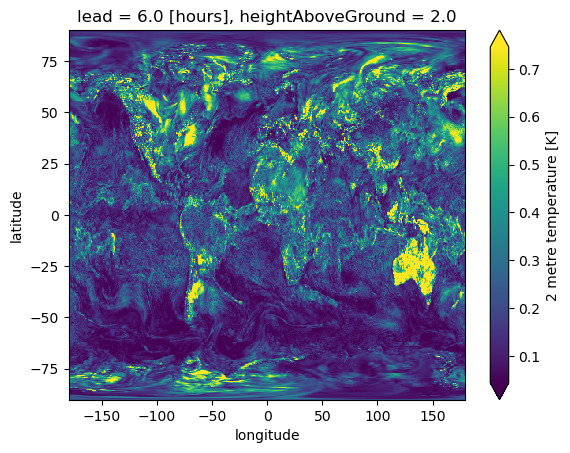

<IPython.core.display.Javascript object>

In [11]:
skill.t2m.plot(robust=True)